In [1]:
#https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/
import tensorflow as tf

#First, you'll need to enable GPUs for the notebook:
#Navigate to Edit→Notebook Settins
#select TPU from the Hardware Accelerator drop-down

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('TPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('TPU')
        print(len(gpus), "Physical TPUs,", len(logical_gpus), "Logical TPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

#First, you'll need to enable TPUs for the notebook:
#Navigate to Edit→Notebook Settins
#select TPU from the Hardware Accelerator drop-down

"""
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
"""

1 Physical CPU, 1 Logical CPU


'\n%tensorflow_version 2.x\nimport tensorflow as tf\nprint("Tensorflow version " + tf.__version__)\n\ntry:\n  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection\n  print(\'Running on TPU \', tpu.cluster_spec().as_dict()[\'worker\'])\nexcept ValueError:\n  raise BaseException(\'ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!\')\n\ntf.config.experimental_connect_to_cluster(tpu)\ntf.tpu.experimental.initialize_tpu_system(tpu)\ntpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)\n'

In [2]:
from google.colab import drive
drive.mount('/input')

Drive already mounted at /input; to attempt to forcibly remount, call drive.mount("/input", force_remount=True).


In [3]:
!ls -l /input/MyDrive/DeepLearning

total 2754171
-rw------- 1 root root  137054052 Jul  3 00:09 CALTECH101_ObjectCategories.zip
-rw------- 1 root root  537507216 Jul  3 00:10 dataset_multi_output_classification.zip
-rw------- 1 root root     215802 Jul  3 00:18 examples_multi_output_classification.zip
-rw------- 1 root root 1162949981 Jul  3 00:22 Food-11.zip
-rw------- 1 root root  446938948 Jul  3 00:19 Food-5K.zip
-rw------- 1 root root     341903 Jul  3 00:24 grad_cam_images.zip
-rw------- 1 root root  186001776 Jul  3 00:06 Houses_Dataset.zip
-rw------- 1 root root    2519901 Jul  3 00:08 Pokemon_examples.zip
-rw------- 1 root root  346739983 Jul  3 00:08 Pokemon.zip


In [4]:
inputdir = "/input/MyDrive/DeepLearning"

In [5]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import random
import pickle
import cv2
# import the necessary packages
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import imutils
import os

In [6]:
class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [8]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32 # * tpu_strategy.num_replicas_in_sync
IMAGE_DIMS = (96, 96, 3)

In [9]:
# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
import zipfile
#imagePaths = sorted(list(paths.list_images('Pokemon')))
imagefilename = os.path.join(inputdir, 'Pokemon.zip')
zf = zipfile.ZipFile(imagefilename)
random.seed(42)
imagePaths = zf.namelist()
random.seed(42)
random.shuffle(imagePaths)

[INFO] loading images...


In [10]:
# initialize the data and labels
data = []
labels = []
from tensorflow.keras.applications import imagenet_utils
# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	#image = cv2.imread(imagePath)
	image = cv2.imdecode(np.frombuffer(zf.read(imagePath), np.uint8), 1)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	#image = img_to_array(image)
	#image = np.expand_dims(image, axis=0)
	image = imagenet_utils.preprocess_input(image)
	data.append(image)
 
	# extract the class label from the image path and update the
	# labels list
	#label = imagePath.split(os.path.sep)[-2]
	label = imagePath.split('/', 1)[0]
	labels.append(label)

In [11]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 252.29MB


In [12]:
print(data.shape)
print(labels.shape)

(1168, 96, 96, 3)
(1168,)


In [13]:
# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [14]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.2, random_state=42)

In [15]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,horizontal_flip=True, fill_mode="nearest")

In [17]:
# initialize the model

print("[INFO] compiling model...")
#with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
#  model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],depth=IMAGE_DIMS[2], classes=len(lb.classes_))
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0

In [19]:
# train the network
print("[INFO] training network...")
H = model.fit(aug.flow(trainX, trainY, batch_size=BS),validation_data=(testX, testY),steps_per_epoch=len(trainX) // BS,epochs=EPOCHS, verbose=1)

[INFO] training network...
Epoch 1/100
29/29 [==============================] - 26s 902ms/step - loss: 1.5115 - accuracy: 0.6064 - val_loss: 2.9157 - val_accuracy: 0.1795
Epoch 2/100
29/29 [==============================] - 26s 891ms/step - loss: 0.8583 - accuracy: 0.7483 - val_loss: 4.8215 - val_accuracy: 0.2265
Epoch 3/100
29/29 [==============================] - 27s 916ms/step - loss: 0.7148 - accuracy: 0.7982 - val_loss: 6.3699 - val_accuracy: 0.3462
Epoch 4/100
29/29 [==============================] - 26s 889ms/step - loss: 0.5871 - accuracy: 0.8149 - val_loss: 3.8717 - val_accuracy: 0.2009
Epoch 5/100
29/29 [==============================] - 26s 888ms/step - loss: 0.5930 - accuracy: 0.8060 - val_loss: 3.7804 - val_accuracy: 0.2051
Epoch 6/100
29/29 [==============================] - 26s 911ms/step - loss: 0.5236 - accuracy: 0.8394 - val_loss: 3.1477 - val_accuracy: 0.3248
Epoch 7/100
29/29 [==============================] - 26s 891ms/step - loss: 0.4848 - accuracy: 0.8481 - val_l

In [20]:
import tempfile
TEMPDIR = tempfile.gettempdir()
# save the model to disk
print("[INFO] serializing network...")
model.save(os.path.join(TEMPDIR, 'cnn_keras.h5'))

[INFO] serializing network...


In [21]:
# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open(os.path.join(TEMPDIR, 'cnn_keras_labelbin.pkl'), "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing label binarizer...


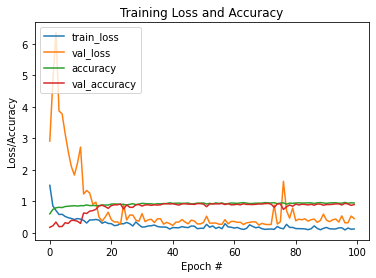

In [22]:
# plot the training loss and accuracy
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
plt.show()

In [23]:
# load the image
zf = zipfile.ZipFile(os.path.join(inputdir, 'Pokemon_examples.zip'))
#image = cv2.imread(os.path.join('Pokemon_examples', 'bulbasaur_plush.png'))
image = cv2.imdecode(np.frombuffer(zf.read('bulbasaur_plush.png'), np.uint8), 1)
output = image.copy()
exampleList = zf.namelist()

In [24]:
# pre-process the image for classification
image = cv2.resize(image, (96, 96))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [25]:
# load the trained convolutional neural network and the label
# binarizer
print("[INFO] loading network...")
model = load_model(os.path.join(TEMPDIR, 'cnn_keras.h5'))
lb = pickle.loads(open(os.path.join(TEMPDIR, 'cnn_keras_labelbin.pkl'), "rb").read())

[INFO] loading network...


In [26]:
# classify the input image
print("[INFO] classifying image...")
proba = model.predict(image)[0]
idx = np.argmax(proba)
label = lb.classes_[idx]

[INFO] classifying image...


In [27]:
print(exampleList)
print(label)

['bulbasaur_plush.png', 'charmander_counter.png', 'charmander_hidden.png', 'mewtwo_toy.png', 'pikachu_toy.png', 'squirtle_plush.png']
squirtle


In [28]:
# we'll mark our prediction as "correct" of the input image filename
# contains the predicted label text (obviously this makes the
# assumption that you have named your testing image files this way)
#filename = os.path.join('Pokemon_examples', 'bulbasaur_plush.png')[os.path.join('Pokemon_examples', 'bulbasaur_plush.png').rfind(os.path.sep) + 1:]
filename = exampleList[exampleList.index('bulbasaur_plush.png')]
correct = "correct" if filename.rfind(label) != -1 else "incorrect"

In [29]:
print(filename)
print(correct)

bulbasaur_plush.png
incorrect


In [30]:
# build the label and draw the label on the image
label = "{}: {:.2f}% ({})".format(label, proba[idx] * 100, correct)
output = imutils.resize(output, width=400)
cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)

array([[[247, 249, 249],
        [228, 230, 239],
        [199, 201, 217],
        ...,
        [238, 234, 239],
        [237, 234, 239],
        [237, 235, 241]],

       [[248, 249, 249],
        [229, 231, 240],
        [199, 202, 217],
        ...,
        [202, 193, 204],
        [193, 185, 198],
        [195, 190, 205]],

       [[248, 250, 250],
        [231, 233, 242],
        [199, 202, 218],
        ...,
        [159, 149, 153],
        [118, 106, 111],
        [ 87,  78,  82]],

       ...,

       [[216, 218, 228],
        [213, 215, 225],
        [216, 218, 228],
        ...,
        [218, 222, 231],
        [211, 216, 226],
        [203, 208, 219]],

       [[214, 216, 226],
        [220, 222, 232],
        [220, 222, 232],
        ...,
        [213, 216, 227],
        [215, 219, 231],
        [212, 216, 227]],

       [[214, 216, 226],
        [219, 221, 231],
        [219, 221, 231],
        ...,
        [199, 206, 219],
        [201, 208, 221],
        [203, 211, 224]]

[INFO] squirtle: 99.54% (incorrect)


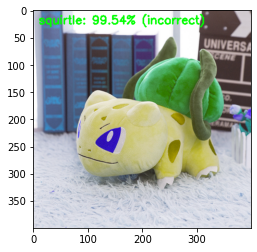

In [31]:
# show the output image
print("[INFO] {}".format(label))
img = cv2.imread('img.jpg')
plt.imshow(output)